In [1]:
from astropy.table import Table
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import stats
from functions import *
import pickle
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.stats import skewnorm, norm
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize
np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font', size=18)
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='DejaVu Sans')

In [3]:
# data_old = Table.read('data_flags_updated_Oct8.dat', format = 'ascii')
data = Table.read('data_flags_updated_Nov1.dat', format = 'ascii')
print(len(data))
catalog =data
ra_boolean = np.logical_and(catalog['ra'] > 110, catalog['ra'] < 270)
catalog_north = catalog[ra_boolean]
strip_boolean = np.logical_and.reduce([catalog_north['ra'] > 250, 
                                       catalog_north['ra'] < 269, 
                                       catalog_north['dec'] > 51, 
                                       catalog_north['dec'] < 67])
catalog_main = catalog_north[~strip_boolean]
data = catalog_main#[catalog_main['redshift']< 0.1026]

707817


In [4]:
# ra,dec,z
ra = np.array(data['ra'])
dec = np.array(data['dec'])
z = np.array(data['redshift'])

In [5]:
#stellar mass
Mstar = np.array(data['Mstar'])
# color
u_r = np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))] 

g_r = np.array(data['g_r'])

# absolute magnitude
rabsmag = np.array(data['rabsmag'])

#star formation rate and specific SPR
SFR  = np.array(data['SFR'])

sSFR = np.array(data['sSFR'])


In [6]:
#classification V^2

wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder

wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

# len(wall_v2)+len(void_v2)+len(edge_v2)+len(out_v2),len(wall_vf)+len(void_vf)+len(edge_vf)+len(out_vf), len(data) #check

In [7]:
len(data)

644144

In [74]:
len(void_v2), len(void_vf)

(217131, 95539)

In [75]:
len(wall_v2), len(wall_vf)

(99884, 190864)

In [8]:
def char(char_, bins_, title='galaxy property', label='x-label', voidfinder=False,x=None,y=None):
    '''
    Plots a histogram for a galaxy charachterstic for wall and void galaxies
    
    arguments:
    
    char_ : (numpy array) charachteristic of galaxy desired for plotting
    bins_ : (numpy linear space) histogram bins
    voidfinder : (bool) True if the classification comes from the voidfinder algorithm, False if it comes from V^2
    x: x coordinate of the location of the algorithm's name 
    y: y coordinate of the location of the algorithm's name
    '''
    if voidfinder == True:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.tick_params(labelsize=22)
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[data['redshift']< 0.1026], bins= bins_)
    
    
    counts_wall,counts_void = np.array(counts_wall)/len(char_wall), np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[data['redshift']< 0.1026])

    color_wall='blue'
    color_void='green'
    if voidfinder ==True:
        color_wall='black'
        color_void='red'

    ax.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall, label = 'Wall' , color=color_wall, histtype='step',linestyle=('dashed'))
    ax.hist(bins_void[:-1], bins=bins_void, weights=counts_void ,label = 'Void', color = color_void,histtype='step')
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

    ax.hist(bins_all[:-1], bins=bins_all, weights=counts_all,  label = 'All', color = 'gray',alpha = 0.2)
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
    
    ax.legend(fontsize=20)
#     plt.title(title, fontsize=18)
    ax.set_xlabel(label, fontsize=26)
    ax.set_ylabel(r"Fraction of galaxies",fontsize=26)
    
    if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
        ax.set_xlim(-12, -24) 
    
#     plt.savefig('figures/'+title+".pdf", format='pdf')
    plt.show()
    
    


### Star mass

In [61]:
# char(Mstar,np.linspace(5.9,12, 135),r'Star_Mass_Voidfinder',r'$\log(M_*/M_\odot)$', voidfinder = True,x=6,y=0.025)
# char(Mstar,np.linspace(5.9,12, 135),r'Star_Mass_V2',r'$\log(M_*/M_\odot)$',x=6,y=00.025)


### Color u_r

In [62]:
# char(u_r,np.linspace(0,4, 170),'Color_u_r_V2',r'$u-r$',x=0.2,y=0.016)
# char(u_r,np.linspace(0,4, 170),'Color_u_r_Voidfinder',r'$u-r$', voidfinder = True,x=0.2,y=0.016)



### Color g_r 

In [10]:
# char(g_r,np.linspace(-0.5,1.5, 170),'Color_g_r_V2',r'$g-r$',x=-0.35,y=0.025)
# char(g_r,np.linspace(-0.5,1.5, 170),'Color_g_r_Voidfinder',r'$g-r$', voidfinder = True,x=-0.35,y=0.025)

### Absolute magnitude

In [63]:
# char(rabsmag,np.linspace(-25,-12.5, 170),'Absolute_Magnitude_V2','Absolute Magnitude',x=-13,y=0.023)
# char(rabsmag,np.linspace(-25,-12.5, 170),'Absolute_Magnitude_Voidfinder','Absolute Magnitude', voidfinder = True,x=-13,y=0.023)


#### Star Formation Rate

In [12]:
# char(SFR,np.linspace(-3,2, 170),'star_formation_rate_V2',r'$\log(M_*/M_\odot yr)$',x=-2.7,y=0.0105)
# char(SFR,np.linspace(-3,2, 170),'star_formation_rate_Voidfinder',r'$\log(M_*/M_\odot yr)$', voidfinder = True,x=-2.7,y=0.012)

#### Specific star Formation Rate

In [13]:
# char(sSFR,np.linspace(-13,-8, 170),'specific_star_formation_rate_V2',r'$\log(M_*/M_\odot yr)$',x=-12.7,y=0.0105)
# char(sSFR,np.linspace(-13,-8, 170),'specific_star_formation_rate_Voidfinder',r'$\log(M_*/M_\odot yr)$', voidfinder = True,x=-12.7,y=0.013)

### errors

In [35]:
# def bin_err(x):  
#     inv_Vmax = 1/(((10)*10**((17.7 - np.array(x))/5))/10**6)**3
#     return np.sqrt(np.sum(inv_Vmax**2))


# def bin_errors(char_,bins_):
    
#     test1=np.digitize(char_, bins=bins_) # gives index of bin where galaxy belongs
    
#     bin_glx_ind=[]  # galaxy indices containes in each absolute magnitude bin
    
#     for i in range(len(bins)):
#         bin_glx_ind.append(np.argwhere(test1==i))
#     bin_glx_ind=np.array(bin_glx_ind)

#     bin_errors=[]
#     for i in range(len(bin_glx_ind)):
#         bin_errors.append(bin_err(char_[bin_glx_ind[i]]))
        
#     bin_errors=np.array(bin_errors)
#     return bin_errors


### fit the distributions with skewnormal distributions

In [10]:
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)
def func_unimodal(x, a, mua, sga, askew):
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) 

In [11]:
def bin_data(data,bins_,label="label me", plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)
    dn1 = np.sqrt(n1)
    x = 0.5*(edges1[1:] + edges1[:-1])
        
#     if plot == True:
#         plt.errorbar(x, n1, yerr=dn1, fmt='.')        
#         plt.xlabel(label, fontsize=18)
#         plt.ylabel('count',fontsize=18) 
#         plt.title("Binned Data ")
#         plt.show()
        
    return  x,n1,dn1 #, popt_void

In [49]:
def fit_bimodal(char_,class_,bins,p0_=None,err=None):
    
    x_data,y_data,dy=bin_data(data=char_[class_],bins_=bins)   
    err[np.argwhere(err==0)]= 0.00001
    s=dy
    popt_, pcov_ = curve_fit(func_bimodal, x_data, y_data,p0=p0_)#, sigma=s)#, sigma=cov)
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_bimodal(x_data, *popt_), 'black') 
    plt.show()
    print(popt_,np.sqrt(np.diag(pcov_)))
    
    return popt_,np.sqrt(np.diag(pcov_))
    

In [37]:
def fit_unimodal(char_,class_,bins,p0_=None,err=None):
    
    x_data,y_data,dy=bin_data(data=char_[class_],bins_=bins)   
    err[np.argwhere(err==0)]= 0.00001
    s=dy
    #fit
    popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data,p0=p0_)#, sigma=s)#, sigma=cov)
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_unimodal(x_data, *popt_), 'black') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.ylabel("Counts")
    plt.show()
    print(popt_,np.sqrt(np.diag(pcov_)))
    
    return popt_,np.sqrt(np.diag(pcov_))
    

#### Mass mean 

wall_v2


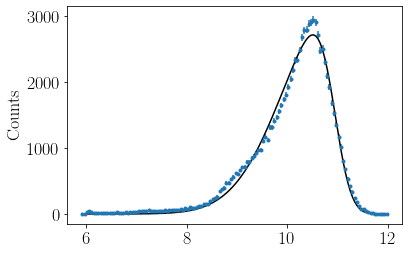

[ 3.94227025e+03  1.09390757e+01  1.00408371e+00 -3.79640301e+00] [3.16433498e+01 6.83296649e-03 1.26744017e-02 1.69844552e-01]

 void_v2


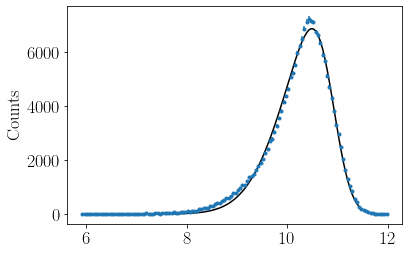

[ 8.84824492e+03  1.08976608e+01  8.31038219e-01 -2.74930418e+00] [4.73342290e+01 5.18453464e-03 8.14541015e-03 8.62012457e-02]

 wall_vf


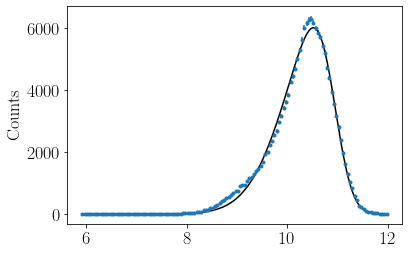

[ 7.73411519e+03  1.09256584e+01  8.33473460e-01 -2.78768389e+00] [4.47107895e+01 5.53057279e-03 8.75877500e-03 9.40447331e-02]

 void_vf


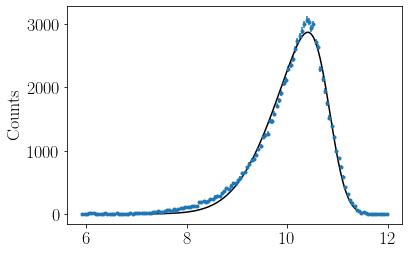

[ 3.91499842e+03  1.08272533e+01  9.17955921e-01 -3.31802784e+00] [2.64399021e+01 5.93339401e-03 1.03151166e-02 1.26001848e-01]


(array([ 3.91499842e+03,  1.08272533e+01,  9.17955921e-01, -3.31802784e+00]),
 array([2.64399021e+01, 5.93339401e-03, 1.03151166e-02, 1.26001848e-01]))

In [36]:

print("wall_v2")
k = bin_data(Mstar[wall_v2],bins_=np.linspace(5.9,12, 135),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_unimodal(char_=Mstar,class_=wall_v2,bins=np.linspace(5.9,12, 135), err=poiss_err,p0_=[ 2000,  10.5,  1.3, 1])

print("\n void_v2")

k = bin_data(Mstar[void_v2],bins_=np.linspace(5.9,12, 135),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_unimodal(char_=Mstar,class_=void_v2,bins=np.linspace(5.9,12, 135), err=poiss_err,p0_=[ 2000,  10.5,  1.3, 1])


print("\n wall_vf")

k = bin_data(Mstar[wall_vf],bins_=np.linspace(5.9,12, 135),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_unimodal(char_=Mstar,class_=wall_vf,bins=np.linspace(5.9,12, 135), err=poiss_err,p0_=[ 2000,  10.5,  1.3, 1])

print("\n void_vf")

k = bin_data(Mstar[void_vf],bins_=np.linspace(5.9,12, 135),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_unimodal(char_=Mstar,class_=void_vf,bins=np.linspace(5.9,12, 135), err=poiss_err,p0_=[ 2000,  10.5,  1.3, 1])


#### Absolute magnitude mean 

wall_v2


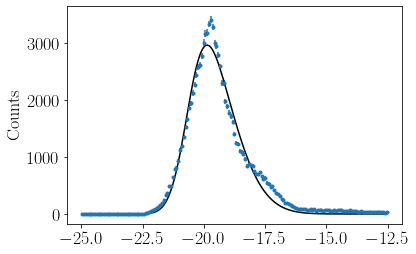

[ 6.95273118e+03 -2.06117144e+01  1.44858226e+00  2.29803709e+00] [7.65318861e+01 2.32804309e-02 3.27306906e-02 1.60250624e-01]

 void_v2


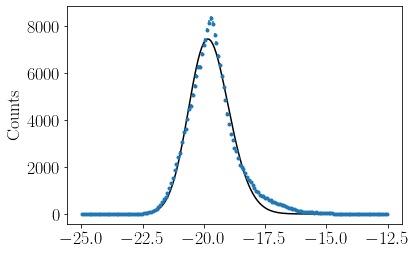

[ 1.52803199e+04 -2.03904255e+01  1.05089789e+00  1.20546842e+00] [1.43561424e+02 4.30559581e-02 3.65562171e-02 1.41448693e-01]

 wall_vf


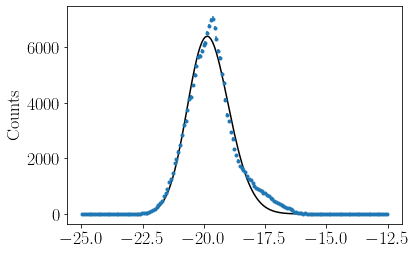

[ 1.35468031e+04 -2.04400201e+01  1.08750106e+00  1.22229500e+00] [1.30313798e+02 4.44061703e-02 3.81527186e-02 1.43692463e-01]

 void_vf


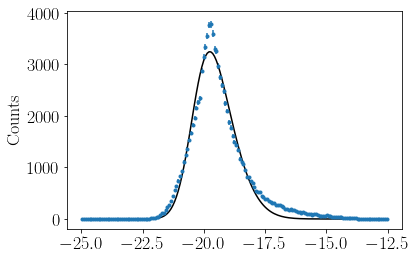

[ 6.57706826e+03 -2.03910523e+01  1.19215016e+00  1.93979773e+00] [7.83479985e+01 2.65421541e-02 3.31430773e-02 1.64088915e-01]


(array([ 6.57706826e+03, -2.03910523e+01,  1.19215016e+00,  1.93979773e+00]),
 array([7.83479985e+01, 2.65421541e-02, 3.31430773e-02, 1.64088915e-01]))

In [35]:

print("wall_v2")
k = bin_data(rabsmag[wall_v2],bins_=np.linspace(-25,-12.5, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_unimodal(char_=rabsmag,class_=wall_v2,bins=np.linspace(-25,-12.5, 170), err=poiss_err,p0_=[ 2000,  -20,  1.3, 1])

print("\n void_v2")

k = bin_data(rabsmag[void_v2],bins_=np.linspace(-25,-12.5, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_unimodal(char_=rabsmag,class_=void_v2,bins=np.linspace(-25,-12.5, 170), err=poiss_err,p0_=[ 2000,  -20,  1.3, 1])


print("\n wall_vf")

k = bin_data(rabsmag[wall_vf],bins_=np.linspace(-25,-12.5, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_unimodal(char_=rabsmag,class_=wall_vf,bins=np.linspace(-25,-12.5, 170), err=poiss_err,p0_=[ 2000,  -20,  1.3, 1])

print("\n void_vf")

k = bin_data(rabsmag[void_vf],bins_=np.linspace(-25,-12.5, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_unimodal(char_=rabsmag,class_=void_vf,bins=np.linspace(-25,-12.5, 170), err=poiss_err,p0_=[ 2000,  -20,  1.3, 1])


#### u-r mean

wall_v2


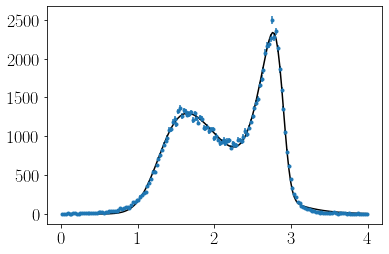

[ 1.54086864e+03  1.28607021e+00  8.02183784e-01  3.37296877e+00
  8.09387665e+02  2.89308697e+00  2.60750380e-01 -3.11578630e+00] [1.62375932e+01 5.05671317e-03 1.43080403e-02 1.38568227e-01
 1.14653201e+01 1.87580648e-03 3.74731720e-03 1.16587371e-01]

 void_v2


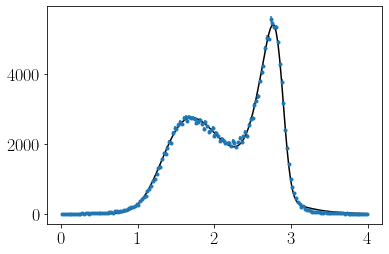

[ 1.86879542e+03  2.89178049e+00  2.55090927e-01 -2.96286898e+00
  3.26253130e+03  1.33560445e+00  7.81015740e-01  3.06559394e+00] [2.12258115e+01 1.52166769e-03 2.94476760e-03 8.86133573e-02
 3.00063902e+01 4.71210525e-03 1.24704989e-02 1.10799297e-01]

 wall_vf


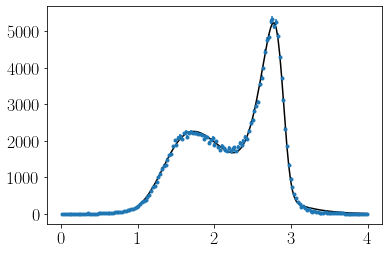

[ 2.73594336e+03  1.35223124e+00  8.00903319e-01  3.06378155e+00
  1.78770504e+03  2.89547660e+00  2.53828294e-01 -3.11853432e+00] [2.79322703e+01 5.40966394e-03 1.36860827e-02 1.22093112e-01
 1.89865864e+01 1.41277006e-03 2.76072198e-03 9.17440037e-02]

 void_vf


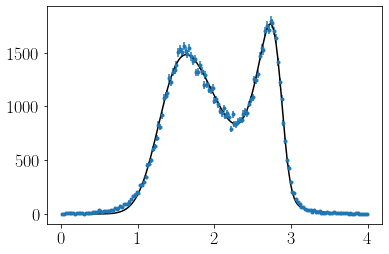

[ 1.58781582e+03  1.29478734e+00  6.98439502e-01  2.88485887e+00
  6.47008204e+02  2.87179782e+00  2.67622665e-01 -2.72357905e+00] [1.65816380e+01 5.25746462e-03 1.43978816e-02 1.26657195e-01
 1.34531030e+01 2.78904751e-03 5.76352735e-03 1.31048474e-01]


(array([ 1.58781582e+03,  1.29478734e+00,  6.98439502e-01,  2.88485887e+00,
         6.47008204e+02,  2.87179782e+00,  2.67622665e-01, -2.72357905e+00]),
 array([1.65816380e+01, 5.25746462e-03, 1.43978816e-02, 1.26657195e-01,
        1.34531030e+01, 2.78904751e-03, 5.76352735e-03, 1.31048474e-01]))

In [52]:
# a, mua, sga, askew, b, mub, sgb, bskew
print("wall_v2")
k = bin_data(u_r[wall_v2],bins_=np.linspace(0,4, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=u_r,class_=wall_v2,bins=np.linspace(0,4, 170), err=poiss_err)#,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])

print("\n void_v2")
k = bin_data(u_r[void_v2],bins_=np.linspace(0,4, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=u_r,class_=void_v2,bins=np.linspace(0,4, 170), err=poiss_err)

print("\n wall_vf")
k = bin_data(u_r[wall_vf],bins_=np.linspace(0,4, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=u_r,class_=wall_vf,bins=np.linspace(0,4, 170), err=poiss_err)

print("\n void_vf")

k = bin_data(u_r[void_vf],bins_=np.linspace(0,4, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=u_r,class_=void_vf,bins=np.linspace(0,4, 170), err=poiss_err,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])


#### g-r means

wall_v2


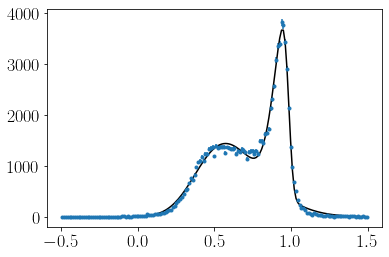

[ 4.11304987e+02  9.84276661e-01  8.60881719e-02 -3.40770490e+00
  7.77671562e+02  4.02992189e-01  3.17239769e-01  1.92855174e+00] [6.67395835e+00 7.89624222e-04 1.58731876e-03 1.83773591e-01
 1.14374018e+01 6.52171531e-03 9.40553539e-03 1.50810860e-01]

 void_v2


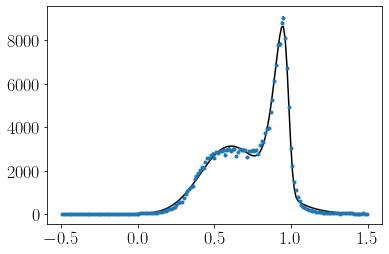

[ 1.66152254e+03  4.49006669e-01  2.92821554e-01  1.54563890e+00
  9.28018941e+02  9.83484152e-01  8.23920599e-02 -3.39799932e+00] [2.34852665e+01 8.52055249e-03 9.44882227e-03 1.43494186e-01
 1.38517584e+01 6.82792594e-04 1.41397243e-03 1.66642701e-01]

 wall_vf


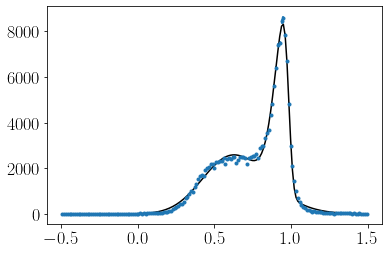

[ 8.85731778e+02  9.84204392e-01  8.07998114e-02 -3.33639653e+00
  1.39274659e+03  4.75774665e-01  2.82524710e-01  1.32105068e+00] [1.28834853e+01 6.50994897e-04 1.36240756e-03 1.57155727e-01
 2.15806677e+01 1.22949901e-02 1.12370124e-02 1.65791284e-01]

 void_vf


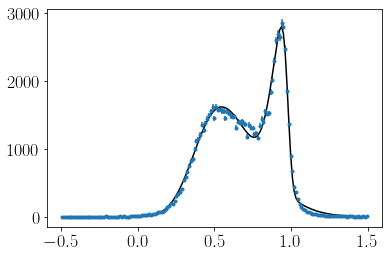

[ 3.13411597e+02  9.78689568e-01  9.09181776e-02 -3.64087518e+00
  8.20570564e+02  3.85854445e-01  3.10128066e-01  2.21772095e+00] [6.08542087e+00 8.79804839e-04 1.84321746e-03 2.15309537e-01
 9.79009474e+00 4.02859721e-03 7.15853310e-03 1.25484425e-01]


(array([ 3.13411597e+02,  9.78689568e-01,  9.09181776e-02, -3.64087518e+00,
         8.20570564e+02,  3.85854445e-01,  3.10128066e-01,  2.21772095e+00]),
 array([6.08542087e+00, 8.79804839e-04, 1.84321746e-03, 2.15309537e-01,
        9.79009474e+00, 4.02859721e-03, 7.15853310e-03, 1.25484425e-01]))

In [84]:
# a, mua, sga, askew, b, mub, sgb, bskew
print("wall_v2")
k = bin_data(g_r[wall_v2],bins_=np.linspace(-0.5,1.5, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=g_r,class_=wall_v2,bins=np.linspace(-0.5,1.5, 170), err=poiss_err)#,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])

print("\n void_v2")
k = bin_data(g_r[void_v2],bins_=np.linspace(-0.5,1.5, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=g_r,class_=void_v2,bins=np.linspace(-0.5,1.5, 170), err=poiss_err)

print("\n wall_vf")
k = bin_data(g_r[wall_vf],bins_=np.linspace(-0.5,1.5, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=g_r,class_=wall_vf,bins=np.linspace(-0.5,1.5, 170), err=poiss_err)

print("\n void_vf")

k = bin_data(g_r[void_vf],bins_=np.linspace(-0.5,1.5, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=g_r,class_=void_vf,bins=np.linspace(-0.5,1.5, 170), err=poiss_err,p0_=np.array([ 8.85731778e+02,  9.84204392e-01,  8.07998114e-02, -3.33639653e+00,
         1.39274659e+03,  4.75774665e-01,  2.82524710e-01,  1.32105068e+00]))

#### SFR

wall_v2


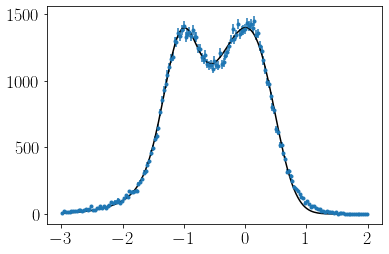

[ 2.11649967e+03  4.61900037e-01  1.03298993e+00 -3.59999322e+00
  5.62237624e+02 -8.98137595e-01  3.31732430e-01 -9.85009688e-01] [2.32627507e+01 4.92009176e-03 1.67558066e-02 1.20264264e-01
 1.83841449e+01 2.75714467e-02 2.15184793e-02 2.25221086e-01]

 void_v2


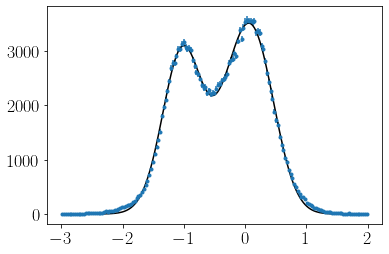

[ 2.22659756e+03 -8.79987619e-01  3.58914057e-01 -7.54784322e-01
  3.68105082e+03  3.69314422e-01  5.68379864e-01 -1.45404751e+00] [8.79020790e+01 3.31285855e-02 1.81572915e-02 2.39622354e-01
 8.79269083e+01 2.34493970e-02 3.80724623e-02 2.09285157e-01]

 wall_vf


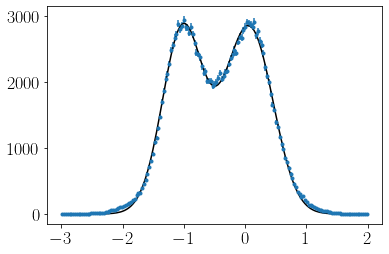

[ 2.97040184e+03  3.43770552e-01  5.39976720e-01 -1.25113613e+00
  2.20002537e+03 -8.79203386e-01  3.63700029e-01 -6.75325896e-01] [8.61455359e+01 3.33148950e-02 4.65489780e-02 2.50790257e-01
 8.62676203e+01 3.92268769e-02 1.91907321e-02 2.55415022e-01]

 void_vf


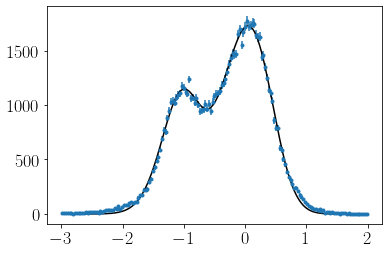

[ 7.50625879e+02 -8.54356593e-01  3.97755177e-01 -1.18296485e+00
  1.87073553e+03  3.85281391e-01  6.25885932e-01 -1.82462336e+00] [4.60989738e+01 2.02320258e-02 1.76038404e-02 2.47264037e-01
 4.61791122e+01 1.83356178e-02 3.82403246e-02 2.19034640e-01]


(array([ 7.50625879e+02, -8.54356593e-01,  3.97755177e-01, -1.18296485e+00,
         1.87073553e+03,  3.85281391e-01,  6.25885932e-01, -1.82462336e+00]),
 array([4.60989738e+01, 2.02320258e-02, 1.76038404e-02, 2.47264037e-01,
        4.61791122e+01, 1.83356178e-02, 3.82403246e-02, 2.19034640e-01]))

In [68]:
# a, mua, sga, askew, b, mub, sgb, bskew
print("wall_v2")
k = bin_data(SFR[wall_v2],bins_=np.linspace(-3,2, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=SFR,class_=wall_v2,bins=np.linspace(-3,2, 170), err=poiss_err)#,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])

print("\n void_v2")
k = bin_data(SFR[void_v2],bins_=np.linspace(-3,2, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=SFR,class_=void_v2,bins=np.linspace(-3,2, 170), err=poiss_err)

print("\n wall_vf")
k = bin_data(SFR[wall_vf],bins_=np.linspace(-3,2, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=SFR,class_=wall_vf,bins=np.linspace(-3,2, 170), err=poiss_err)

print("\n void_vf")

k = bin_data(SFR[void_vf],bins_=np.linspace(-3,2, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=SFR,class_=void_vf,bins=np.linspace(-3,2, 170), err=poiss_err,p0_=[ 2000,  -1.5,  1.3, 1,2000,0.7,1,1])


#### sSFR means

wall_v2


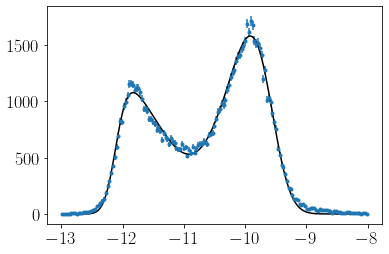

[ 1.56867689e+03 -9.59261670e+00  6.18664599e-01 -2.30476571e+00
  1.10698530e+03 -1.21105197e+01  7.40576574e-01  4.85872184e+00] [2.26873914e+01 7.92501968e-03 1.71919999e-02 1.41728937e-01
 2.31420234e+01 5.80615872e-03 2.38237358e-02 3.53361186e-01]

 void_v2


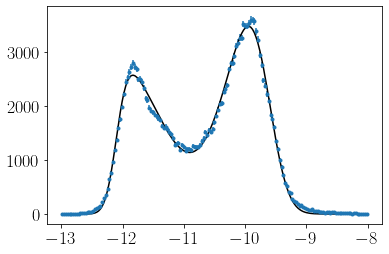

[ 3.37262376e+03 -9.63238546e+00  5.92482397e-01 -2.18559409e+00
  2.53826436e+03 -1.21000710e+01  7.09101245e-01  4.89623511e+00] [3.72943521e+01 6.98178184e-03 1.36697555e-02 1.16153737e-01
 3.81100285e+01 4.39041058e-03 1.67272644e-02 2.76447271e-01]

 wall_vf


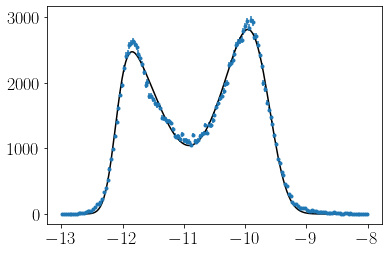

[ 2.84893211e+03 -9.62751880e+00  6.45861921e-01 -2.56198213e+00
  2.31661086e+03 -1.21101204e+01  6.68712112e-01  4.51212780e+00] [3.42455239e+01 6.58242018e-03 1.52844380e-02 1.36015084e-01
 3.43704008e+01 4.15898453e-03 1.52907638e-02 2.39940655e-01]

 void_vf


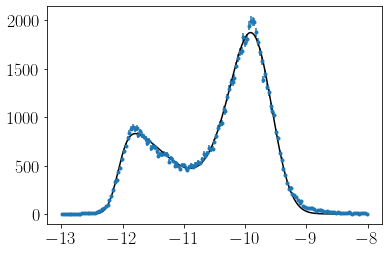

[ 1.65847628e+03 -9.62867726e+00  5.05964645e-01 -1.63287508e+00
  9.72214331e+02 -1.20718912e+01  8.69754208e-01  6.38032855e+00] [2.24038714e+01 9.37628962e-03 1.37422789e-02 1.07290102e-01
 2.37410750e+01 6.48370556e-03 3.20533589e-02 5.56703588e-01]


(array([ 1.65847628e+03, -9.62867726e+00,  5.05964645e-01, -1.63287508e+00,
         9.72214331e+02, -1.20718912e+01,  8.69754208e-01,  6.38032855e+00]),
 array([2.24038714e+01, 9.37628962e-03, 1.37422789e-02, 1.07290102e-01,
        2.37410750e+01, 6.48370556e-03, 3.20533589e-02, 5.56703588e-01]))

In [76]:
# a, mua, sga, askew, b, mub, sgb, bskew
print("wall_v2")
k = bin_data(sSFR[wall_v2],bins_=np.linspace(-13,-8, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=sSFR,class_=wall_v2,bins=np.linspace(-13,-8, 170), err=poiss_err,p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1])

print("\n void_v2")
k = bin_data(sSFR[void_v2],bins_=np.linspace(-13,-8, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=sSFR,class_=void_v2,bins=np.linspace(-13,-8, 170), err=poiss_err,p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1])


print("\n wall_vf")
k = bin_data(sSFR[wall_vf],bins_=np.linspace(-13,-8, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=sSFR,class_=wall_vf,bins=np.linspace(-13,-8, 170), err=poiss_err,p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1])


print("\n void_vf")

k = bin_data(sSFR[void_vf],bins_=np.linspace(-13,-8, 170),label="label me", plot=False)
x,poiss_err=k[0],k[2]
fit_bimodal(char_=sSFR,class_=void_vf,bins=np.linspace(-13,-8, 170), err=poiss_err,p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1])



### extract the mean and the error in the mean from the fit results

### Calculate averages and medians

In [9]:
from scipy import stats

In [10]:
def remove_nan(array):
    return array[np.logical_not(np.isnan(array))]

In [13]:
def stat(char_,voidfinder =False):
    '''
    char : array with galaxy properties e.g : Mstar
    voidfinder : true if we want to calculate the statistics of voidfinder data and not V^2 data
    
    note 1 : shifts are taken as void-wall
    note 2: percent difference are calculated with respect to the wall distribution
    
    returns: average, std of average, average shift, std of average shift, percent diff of avg , median, median shift, 
    percent diff of median
    '''
    if voidfinder==True:
        char_void= remove_nan(char_[void_vf])
        char_wall=remove_nan(char_[wall_vf])
        
    else:
        char_void= remove_nan(char_[void_v2])
        char_wall=remove_nan(char_[wall_v2])
        
    avg_void = np.mean(char_void)
    avg_wall = np.mean(char_wall)
        
    avg_shift=  avg_wall-avg_void
        
    std_avg_void = np.std(char_void,ddof=1)/np.sqrt(len(char_void))
    std_avg_wall = np.std(char_wall,ddof=1)/np.sqrt(len(char_wall))
    
    std_avg_shift = np.sqrt(std_avg_void**2 + std_avg_wall**2)
        
    percent_diff_avg = (avg_shift/avg_wall)*100
    
    median_wall = np.median(char_wall)
    median_void = np.median(char_void)
    
    median_shift = median_wall-median_void
    
    percent_diff_median = (median_shift/median_wall)*100
    
    mode_wall = stats.mode(char_wall,axis=None)[0][0]
    mode_void = stats.mode(char_void,axis=None)[0][0]
    
    mode_shift = mode_wall-mode_void
    percent_diff_mode = (mode_shift/mode_wall)*100
    
    print('average void : %.3f \pm %.3f' %(avg_void, std_avg_void))
    print('median void : %.3f' %median_void)
    print('average shift w.r.t wall :  %.3f \pm %.3f'%(avg_shift, std_avg_shift))
    print('percent difference in avg w.r.t wall : %.3f percent' %(percent_diff_avg))
    print('median shift w.r.t wall: %.3f' %median_shift)
    print('percent difference in median w.r.t wall : %.3f percent' %percent_diff_median)
    print("\n")
    print('average wall :  %.3f \pm %.3f'%(avg_wall, std_avg_wall))
    print('median wall : %.3f' %median_wall)
    print("\n")
    
#     print('mode void : ', mode_void)
#     print('mode wall : ', mode_wall)
#     print('percent difference in mode w.r.t wall : ', percent_diff_mode)


In [14]:
print("\t \tStellar Mass \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(Mstar, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(Mstar)
print("----------------------------------------------- \n")

print("\t \tu-r \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(u_r, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(u_r)
print("----------------------------------------------- \n")

print("\t \tg-r \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(g_r, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(g_r)
print("----------------------------------------------- \n")

print("\t \tAbsolute Magnitude \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(rabsmag, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(rabsmag)
print("----------------------------------------------- \n")

print("\t \tStar formation Rate \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(SFR, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(SFR)
print("----------------------------------------------- \n")

print("\t \tSpecific Star Formation Rate \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(sSFR, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(sSFR)
print("----------------------------------------------- \n")

	 	Stellar Mass 

--------------------VOIDFINDER--------------------------- 

average void : 10.067 \pm 0.002
median void : 10.201
average shift w.r.t wall :  0.206 \pm 0.003
percent difference in avg w.r.t wall : 2.004 percent
median shift w.r.t wall: 0.162
percent difference in median w.r.t wall : 1.560 percent


average wall :  10.273 \pm 0.001
median wall : 10.363



----------------------V2------------------------- 

average void : 10.236 \pm 0.001
median void : 10.334
average shift w.r.t wall :  -0.136 \pm 0.003
percent difference in avg w.r.t wall : -1.351 percent
median shift w.r.t wall: -0.073
percent difference in median w.r.t wall : -0.711 percent


average wall :  10.100 \pm 0.003
median wall : 10.261


----------------------------------------------- 

	 	u-r 

--------------------VOIDFINDER--------------------------- 

average void : 2.038 \pm 0.004
median void : 2.016
average shift w.r.t wall :  0.184 \pm 0.004
percent difference in avg w.r.t wall : 8.273 percent
median s

In [59]:
from pprint import pprint
pprint ([(i, stats.ks_2samp(Mstar[void_vf][:i], Mstar[void_v2][:i])[1]) for i in range(28030,28050,1)])

[(28030, 7.51041978288069e-174),
 (28031, 7.51112501280458e-174),
 (28032, 6.080500769989609e-174),
 (28033, 4.922160259265115e-174),
 (28034, 4.922618322053986e-174),
 (28035, 3.872615230637093e-174),
 (28036, 3.985058155980502e-174),
 (28037, 4.100753294382337e-174),
 (28038, 3.2259293446465045e-174),
 (28039, 2.5375523824269326e-174),
 (28040, 2.05377035149131e-174),
 (28041, 1.662152270855002e-174),
 (28042, 1.3072268294417644e-174),
 (28043, 1.0280164375313605e-174),
 (28044, 8.318635365718304e-175),
 (28045, 8.561036329924057e-175),
 (28046, 1.0888689043393612e-174),
 (28047, 1.3848209441376629e-174),
 (28048, 1.1206789993976503e-174),
 (28049, 1.1533056335887127e-174)]


In [52]:
from scipy.stats import norm
sigma = norm.isf(10**(-200))

In [53]:
sigma

30.20559417957964